In [3]:
import pandas as pd
import openpyxl
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import MSTL
from statsmodels.tsa.arima.model import ARIMA
import numpy as np
import pickle
import scipy

In [34]:
df = pd.read_excel("EMHIRES_PVGIS_TSh_CF_n2_19862015_reformatt.xlsx", usecols='AZ') # Corresponds to Karlsruhe DE12 Nuts-2 code

In [41]:
df.to_pickle('solar_generation_karlsruhe.pkl')

In [2]:
sgk = pd.read_pickle('solar_generation_karlsruhe.pkl')

In [4]:
sgk.describe()
sgk.shape

(262968, 1)

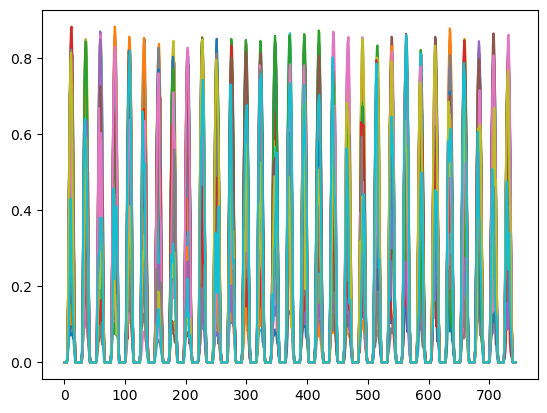

In [59]:
may_series = {}
for i in range(30):
    may_series[i] = sgk['DE12'][i*365*24 + 121*24: i*365*24 + 121*24 + 31*24]
    may_series[i].reset_index(drop=True, inplace=True)
    may_series[i].plot()


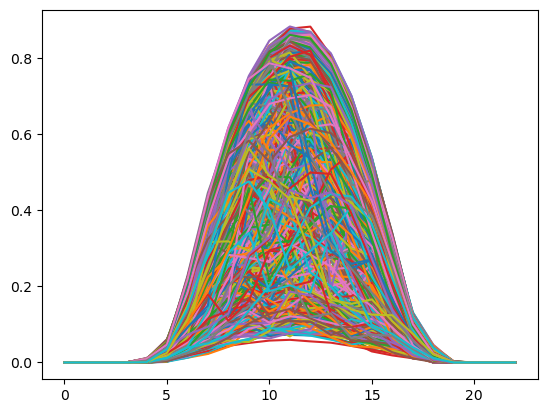

In [28]:
may_day_series = {}
for i in range(30):
    for j in range(31):
        idx = i*31 + j
        may_day_series[idx] = sgk['DE12'][i*365*24 + 121*24 + j*24: i*365*24 + 121*24 + (j+1)*24 - 1]
        may_day_series[idx].reset_index(drop=True, inplace=True)
        may_day_series[idx].plot()

In [29]:
may_day_df = pd.DataFrame(may_day_series)

In [35]:
may_day_df["mean"] = may_day_df.mean(axis=1)

In [139]:
QUANTILES = [0.01, 0.05, 0.1, 0.25, 0.33, 0.5, 0.66, 0.75, 0.9, 0.95, 0.99]
for q in QUANTILES:
    may_day_df[f"q={q}"] = may_day_df.quantile(q=q, axis=1)

<Axes: >

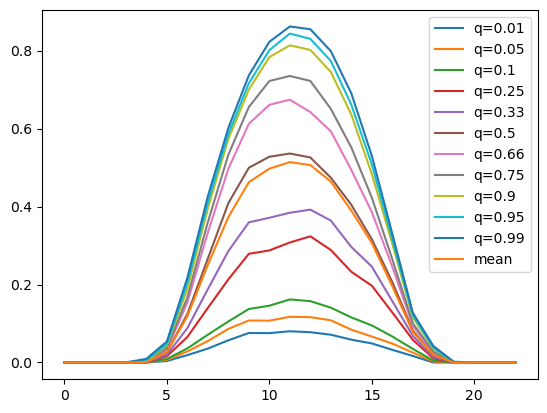

In [140]:
cols = [f"q={q}" for q in QUANTILES]
cols.append("mean")
may_day_df[cols].plot()

In [145]:
may_day_df.to_excel('may_day_df.xlsx')

In [54]:
may_day_df_centered = may_day_df.sub(may_day_df['mean'], axis=0)
may_day_df_div = may_day_df.div(may_day_df["mean"], axis = 0)


<Axes: >

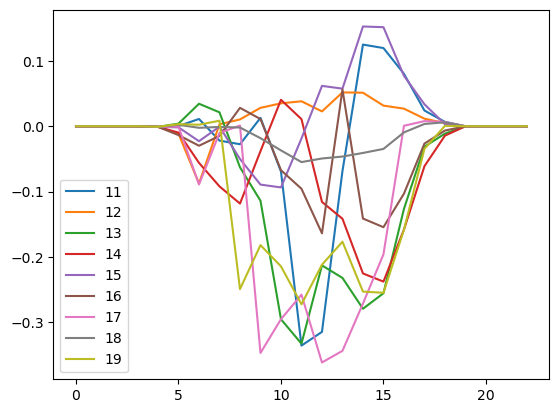

In [53]:
may_day_df_centered[range(11,20)].plot()

<Axes: >

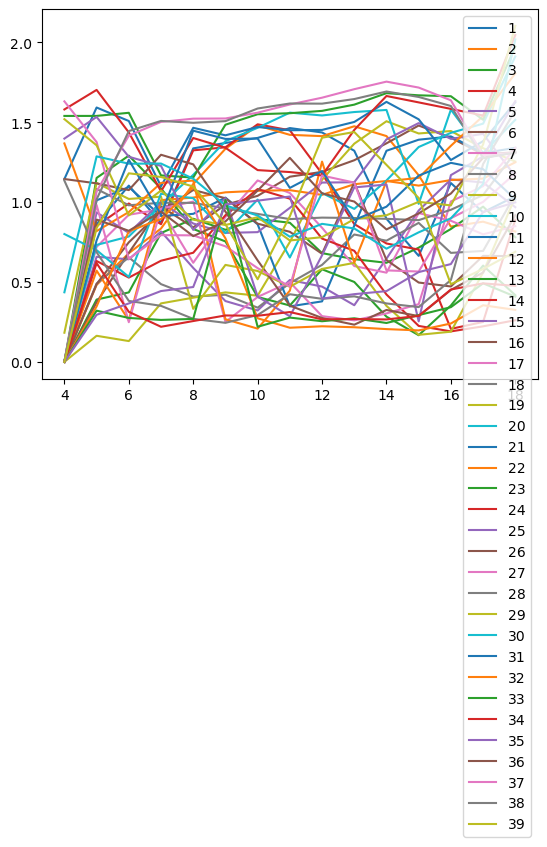

In [153]:
may_day_df_div.loc[4:18, range(1,40)].plot()

In [188]:
params = []
maes = []
mses = []
sigma2s = []

for i in range(30):
    res = ARIMA(may_day_df_centered.loc[4:18,i], order=(1,0,0)).fit()
    
    print(res.summary())
    params.append(res.params['ar.L1'])
    maes.append(res.mae)
    mses.append(res.mse)
    sigma2s.append(res.params['sigma2'])

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   15
Model:                 ARIMA(1, 0, 0)   Log Likelihood                  16.479
Date:                Wed, 07 Jun 2023   AIC                            -26.958
Time:                        12:39:37   BIC                            -24.834
Sample:                             0   HQIC                           -26.981
                                 - 15                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0479      0.098      0.491      0.624      -0.143       0.239
ar.L1          0.7644      0.198      3.864      0.000       0.377       1.152
sigma2         0.0061      0.002      2.547      0.0

/Users/maxv/anaconda3/envs/grb_env/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [190]:
print(np.mean(params))
print(np.mean(maes))
print(np.mean(mses))
print(np.sqrt(np.mean(sigma2s)))

0.6513491937337494
0.055110909343204326
0.005630699293864738
0.0742033755900329


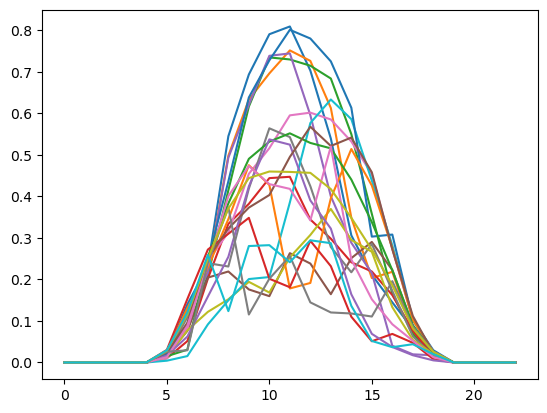

In [34]:
for i in range(20):
    may_day_series[i].plot()

<Axes: >

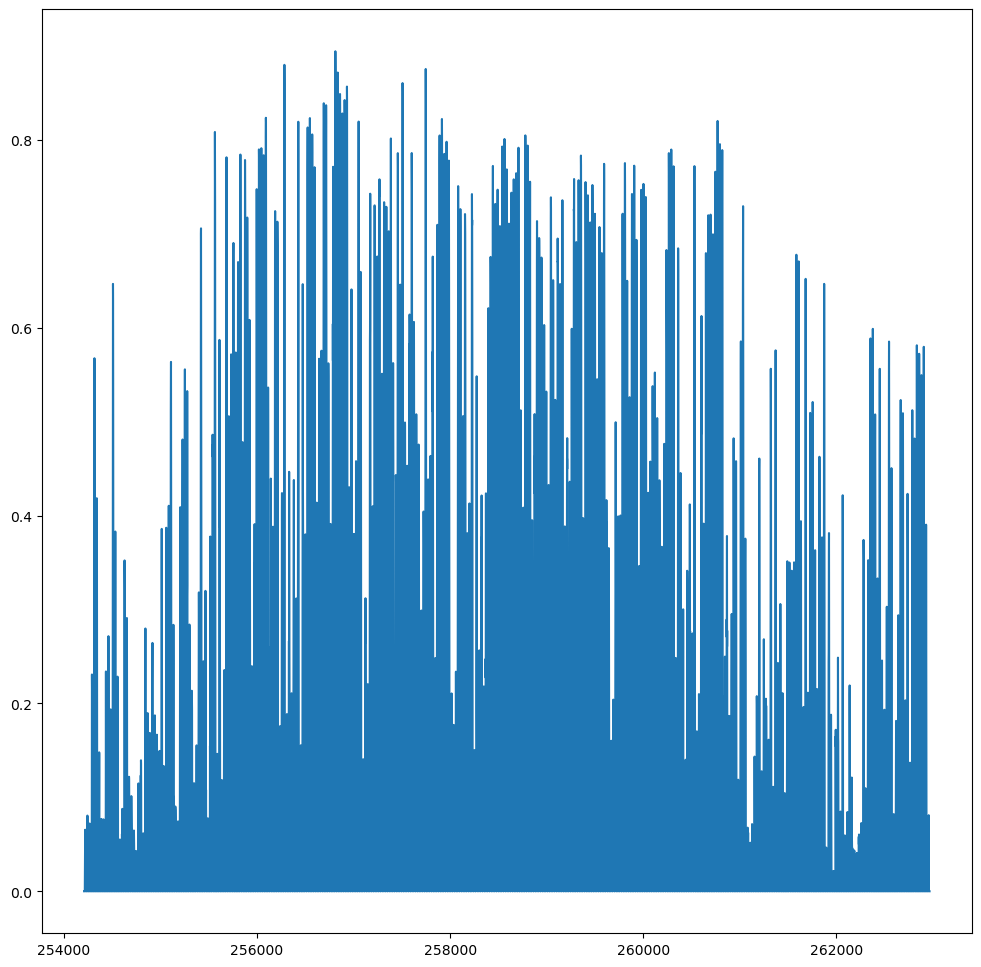

In [7]:
sgk['DE12'][-24*365:].plot(figsize=(12,12))

In [9]:
result = MSTL(sgk['DE12'][-24*365*3:], periods=[24, 24*365]).fit() #, model=’multiplicative)

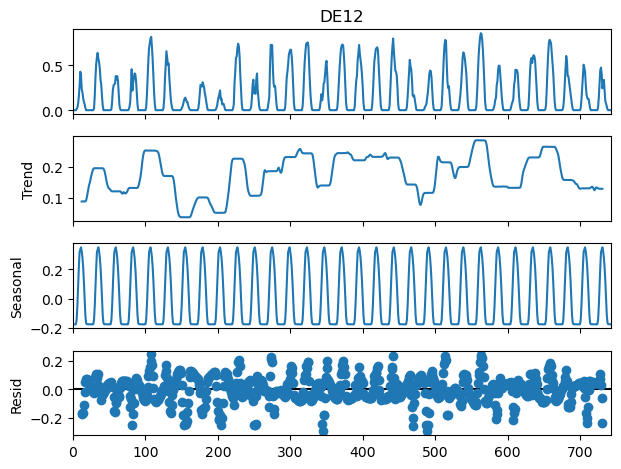

In [94]:
result = seasonal_decompose(may_series[29],model = "additive", period=24)
fig = result.plot()
may_series_resid = result.resid

In [63]:
result = seasonal_decompose(may_series[0], model = "multiplicative", period=24)
fig = result.plot()

ValueError: Multiplicative seasonality is not appropriate for zero and negative values

In [129]:
ar1_model = ARIMA(may_series[29], order = (1,0,0))
ar1_res = ar1_model.fit()

In [131]:
print(ar1_res.mae)
ar1_res.summary()

0.05403049221791913


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   DE12   No. Observations:                  744
Model:                 ARIMA(1, 0, 0)   Log Likelihood                 826.452
Date:                Mon, 05 Jun 2023   AIC                          -1646.903
Time:                        20:03:16   BIC                          -1633.067
Sample:                             0   HQIC                         -1641.570
                                - 744                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1660      0.067      2.461      0.014       0.034       0.298
ar.L1          0.9388      0.016     58.865      0.000       0.907       0.970
sigma2         0.0063      0.000     22.073      0.000       0.006       0.007
===================================================================================
Ljung-Box (L1) (Q):                 380.41   Jarque-Bera (JB):                74.56
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.35   Skew:                             0.48
Prob(H) (two-sided):                  0.02   Kurtosis:                         4.22
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [136]:
ar1_model.simulate(params=ar1_res.params, nsimulations=10)

0    0.436325
1    0.429731
2    0.401724
3    0.219756
4    0.236597
5    0.170363
6    0.157258
7    0.007892
8    0.032307
9   -0.047305
Name: DE12, dtype: float64

In [125]:
ar1_model = ARIMA(may_series_resid, order = (1,0,0))
ar1_res = ar1_model.fit()

In [128]:
ar1_res.summary()
ar1_res.mae

nan

# Quantization

In [23]:
N = 9
q_step = 1 / N
q = [i * q_step for i in range(N+1)]

quantiles = [scipy.stats.norm.ppf(q[i]) for i in range(0,N+1)]

assert len(q) == len(quantiles)

samples = np.random.normal(size=int(1e7))

means = []
for i in range(1,N+1):
    relevant_samples = samples[ (samples > quantiles[i-1]) & (samples <= quantiles[i]) ]
    means.append(np.mean(relevant_samples))

In [26]:
with open('standard_normal_quantization.pkl', 'wb') as f:
    pickle.dump(means, f)